In [44]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline
import umap
import warnings;
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# işlem yapılacak veri sayısını verir.
df.shape

(541909, 8)

In [6]:
# eksik değerleri kontrol eder.
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# eksik olan değerleri kaldırır.
df.dropna(inplace=True)
df['StockCode']= df['StockCode'].astype(str)

In [9]:
#veri setindeki benzersiz müşteri sayısını kontrol eder
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [10]:
# müşteri Id'lerini karıştırır
random.shuffle(customers)

# müşteri Id'lerinin %90'ını çıkarır.
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# verileri train ve validationa ayırır.
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [11]:
# müşterilerin satın alma geçmişini yakalamak için liste
purchases_train = []

# listeyi ürün kodlarıyla doldurur
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:05<00:00, 661.90it/s]


In [12]:
# müşterilerin satın alma geçmişini yakalamak için liste
purchases_val = []

# listeyi ürün kodlarıyla doldurur
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 882.21it/s]


In [17]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3644115, 3682280)

In [14]:
#modeli bellek için daha verimli hale getirir.
model.init_sims(replace=True)

In [15]:
#model özetini verir.
print(model)

Word2Vec(vocab=3165, vector_size=100, alpha=0.03)


In [40]:
#tüm vektörleri çıkarır
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
X.shape


(3165, 100)

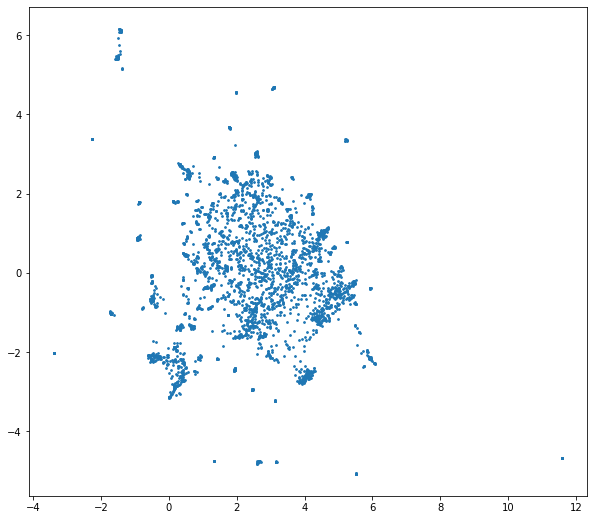

In [46]:
#Word2Vec gömmelerini görselleştirir.
import umap.umap_ as umap
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [47]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [48]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [100]:
def similar_products(v, n):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [101]:
#tek bir ürün vektörüne göre benzer ürün önerme
similar_products(model['90019A'],6)


[('GREEN HEART OF GLASS BRACELET', 0.7540398836135864),
 ('RASPBERRY ANT COPPER FLOWER NECKLAC', 0.7349941730499268),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7250878810882568),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.7189257144927979),
 ('PINK BOUDICCA LARGE BRACELET', 0.7174538969993591),
 ('PINK HEART OF GLASS BRACELET', 0.7141682505607605)]

In [102]:
#geçmiş satın alma işlemine göre önerme
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [103]:
#Bir kullanıcı tarafından satın alınan ürünlerin ilk listesinin uzunluğu
len(purchases_val[0])

312

In [104]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [105]:
#sistemimiz bir kullanıcının tüm satın alma geçmişine dayalı olarak 6 ürün önerdi.
similar_products(aggregate_vectors(purchases_val[0]),6)

[('WOOD 2 DRAWER CABINET WHITE FINISH', 0.7128972411155701),
 ('WOODEN FRAME ANTIQUE WHITE ', 0.6914558410644531),
 ('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.6851314902305603),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.6688750982284546),
 ('WOODEN PICTURE FRAME WHITE FINISH', 0.6672549247741699),
 ('KNITTED UNION FLAG HOT WATER BOTTLE', 0.6525658369064331)]

In [108]:
#satın alınan son 10 ürün
similar_products(aggregate_vectors(purchases_val[0][-10:]),6)

[('WOODEN FRAME ANTIQUE WHITE ', 0.7166886925697327),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.7086178660392761),
 ('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.6895867586135864),
 ('WOODEN PICTURE FRAME WHITE FINISH', 0.6654173731803894),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.6648159623146057),
 ('GLASS STAR FROSTED T-LIGHT HOLDER', 0.6428074836730957)]